In [46]:
# create model
from model import create_model
from src.common import *
from scipy.io import loadmat
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from src.joint_bayesian import *
from sklearn.preprocessing import LabelEncoder

In [47]:
# load weights
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [48]:
import numpy as np
import os.path
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/shape_predictor_68_face_landmarks.dat')

def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg' or ext == '.png':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

In [49]:
embedded = []
metadata_curated = []
label = []

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    if img is None:
        pass
    else:
        # scale RGB values to interval [0,1]
        img = (img / 255.).astype(np.float32)
        metadata_curated.append(IdentityMetadata(m.base, m.name, m.file))
        label.append(m.name)
        # obtain embedding vector for image
        embedded.append(nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0])
metadata_curated = np.array(metadata_curated)
embedded = np.array(embedded)
label = np.array(label)

In [50]:
data_to_pkl(embedded, "OpenFace_MOT360_fetures.pkl")

Saving data to file(OpenFace_MOT360_fetures.pkl). 


True

In [41]:
# with open("OpenFace_MOT360_fetures.pkl", "rb") as f:
#     embedded = pickle.load(f)

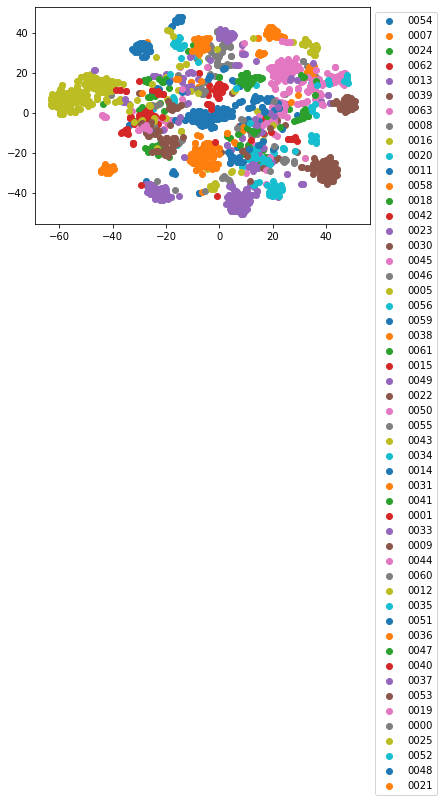

In [51]:
from sklearn.manifold import TSNE

targets = np.array([m.name for m in metadata_curated])
X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

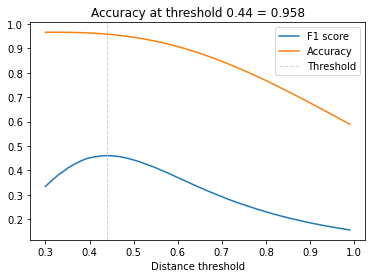

In [52]:
from sklearn.metrics import f1_score, accuracy_score

def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata_curated)

for i in range(num - 1):
    for j in range(i + 1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata_curated[i].name == metadata_curated[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();


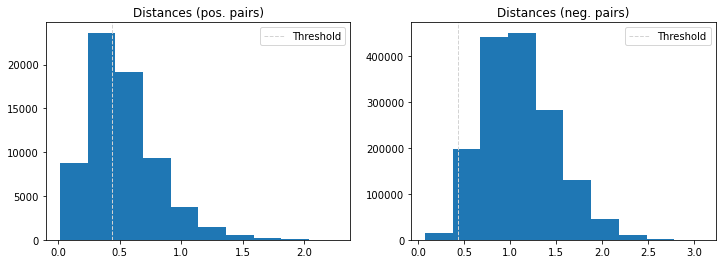

In [53]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

In [57]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata_curated])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

# train_idx = np.random.randint(y.shape[0], size=int(len(y)*0.8))
# test_idx = np.random.randint(y.shape[0], size=int(len(y)*0.2))

# data_to_pkl(train_idx, "data/train_idx_identification.pkl")
# data_to_pkl(test_idx, "data/test_idx_identification.pkl")

with open("data/train_idx_identification.pkl", "rb") as f:
    train_idx = pickle.load(f)
    
with open("data/test_idx_identification.pkl", "rb") as f:
    test_idx = pickle.load(f)

y_train = y[train_idx]
y_test = y[test_idx]

X_train = embedded[train_idx]
X_test = embedded[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.8950276243093923, SVM accuracy = 0.8480662983425414


In [119]:
targets = np.array([m.name for m in metadata_curated])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

# train_idx = np.random.randint(y.shape[0], size=int(len(y)*0.7))
# test_idx = np.random.randint(y.shape[0], size=int(len(y)*0.3))

# data_to_pkl(train_idx, "data/train_idx_identification.pkl")
# data_to_pkl(test_idx, "data/test_idx_identification.pkl")

with open("data/train_idx_verification.pkl", "rb") as f:
    train_idx = pickle.load(f)
    
with open("data/test_idx_verification.pkl", "rb") as f:
    test_idx = pickle.load(f)

y_train = y[train_idx]
y_test = y[test_idx]

X_train = embedded[train_idx]
X_test = embedded[test_idx]

In [120]:
with open("data/IntraPersonPair.pkl", "rb") as f:
    IntraPersonPair = pickle.load(f)
    
with open("data/ExtraPersonPair.pkl", "rb") as f:
    ExtraPersonPair = pickle.load(f)

print(len(IntraPersonPair))
print(len(ExtraPersonPair))
IntraPersonPair = IntraPersonPair[:6000]
ExtraPersonPair = ExtraPersonPair[:6000]

6000
6000


In [121]:
def excute_train(data, label):

    # pca training.
    pca = PCA_Train(data, 128)
    data_pca = pca.transform(data)
    
    JointBayesian_Train(data_pca, label)

In [122]:
excute_train(X_train, y_train)

2020-08-15, 17:40:39  number of components: 128
2020-08-15, 17:40:39  PCA training (n_components=128)...


C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\num

2020-08-15, 17:40:40  PCA done.
(1269, 128)
prepare done, maxNumberInOneClass= 163
2020-08-15, 17:40:41  Iterations-0: 0.0009333134109256732
Saving data to file(./G.pkl). 
Saving data to file(./A.pkl). 
2020-08-15, 17:40:42  Iterations-1: 0.0013080158895057328
2020-08-15, 17:40:43  Iterations-2: 0.001169603312320888
2020-08-15, 17:40:43  Iterations-3: 0.0011486519152167352
2020-08-15, 17:40:44  Iterations-4: 0.001078286187406303
2020-08-15, 17:40:45  Iterations-5: 0.0010199048268824437
2020-08-15, 17:40:45  Iterations-6: 0.0010876230131323808
2020-08-15, 17:40:46  Iterations-7: 0.0011127389868258362
2020-08-15, 17:40:47  Iterations-8: 0.0010973731567820132
2020-08-15, 17:40:47  Iterations-9: 0.0010225232423724177
2020-08-15, 17:40:48  Iterations-10: 0.0005947024722307528
Saving data to file(./G.pkl). 
Saving data to file(./A.pkl). 
2020-08-15, 17:40:49  Iterations-11: 0.00019031387497101744
Saving data to file(./G.pkl). 
Saving data to file(./A.pkl). 
2020-08-15, 17:40:49  Iterations-1

In [123]:
with open("A.pkl", "rb") as f:
    A = pickle.load(f)
with open("G.pkl", "rb") as f:
    G = pickle.load(f)
clt_pca = joblib.load("pca_model.m")
data = clt_pca.transform(X_test)
data_to_pkl(data, "pca_lfw.pkl")

Saving data to file(pca_lfw.pkl). 


True

In [124]:
dist_Intra = get_ratios(A, G, IntraPersonPair, data)
dist_Extra = get_ratios(A, G, ExtraPersonPair, data)

dist_all = dist_Intra + dist_Extra
dist_all = np.asarray(dist_all)
label    = np.append(np.repeat(1, len(dist_Intra)), np.repeat(0, len(dist_Extra)))

data_to_pkl({"distance": dist_all, "label": label}, "result.pkl")

Saving data to file(result.pkl). 


True

In [125]:
excute_performance("result.pkl", -16.9, -16.6, 0.01)

[1 1 1 ... 0 0 0]
test size:  (12000,)
negative size:  (6000,)
postive size:  (6000,)
threshold:  -16.9
             precision    recall  f1-score   support

      False       0.78      0.99      0.87      6000
       True       0.98      0.72      0.83      6000

avg / total       0.88      0.85      0.85     12000

threshold:  -16.889999999999997
             precision    recall  f1-score   support

      False       0.78      0.99      0.87      6000
       True       0.98      0.72      0.83      6000

avg / total       0.88      0.85      0.85     12000

threshold:  -16.879999999999995
             precision    recall  f1-score   support

      False       0.78      0.99      0.87      6000
       True       0.98      0.72      0.83      6000

avg / total       0.88      0.85      0.85     12000

threshold:  -16.869999999999994
             precision    recall  f1-score   support

      False       0.78      0.99      0.87      6000
       True       0.98      0.72      0.83      